# Interpreting One-Hot Encoded Coefficients

## Introduction

You have already seen some examples of how to interpret coefficients for multiple linear regression. In this lesson we will go over some more examples, particularly focusing on models with one-hot encoded categorical predictors.

## Objectives

You will be able to:

* Describe and apply the concept of a reference category
* Interpret coefficients for one-hot encoded variables
* Explain the implications of binning and dropping multiple categories with one-hot encoded variables

## Reference Categories

Let's look at the Auto MPG dataset, with an engineered `make` feature. Then we'll start with a multiple regression model that uses `weight`, `model year`, and `origin` to predict `mpg`.

In [5]:
import pandas as pd

# Load data into pandas and engineer "make" feature
data = pd.read_csv("auto-mpg.csv")
data["make"] = data["car name"].str.split().apply(lambda x: x[0])

data

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,make
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu,chevrolet
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320,buick
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite,plymouth
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst,amc
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino,ford
...,...,...,...,...,...,...,...,...,...,...
387,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl,ford
388,44.0,4,97.0,52,2130,24.6,82,2,vw pickup,vw
389,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage,dodge
390,28.0,4,120.0,79,2625,18.6,82,1,ford ranger,ford


In [6]:
# Prepare y and X for modeling
y = data["mpg"]
X = data[["weight", "model year", "origin"]]

# origin is categorical and needs to be numeric to run regression
X = pd.get_dummies(X, columns=["origin"], drop_first=True, dtype=int) 

In [7]:
import statsmodels.api as sm

model = sm.OLS(y,X)
results = model.fit()

print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                    mpg   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                              5014.
Date:                Tue, 10 Sep 2024   Prob (F-statistic):                        0.00
Time:                        12:29:57   Log-Likelihood:                         -1036.4
No. Observations:                 392   AIC:                                      2081.
Df Residuals:                     388   BIC:                                      2097.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In the model displayed above, we have dropped one of the dummy variable columns for `origin`, in order to avoid the **dummy variable trap**. The dropped column is now our **reference category**.

So, which column is that?

To investigate this, we need to look at the values of `origin` prior to one-hot encoding:

In [9]:
data["origin"].value_counts()

origin
1    245
3     79
2     68
Name: count, dtype: int64

(`1` means a US car maker, `2` means a European car maker, `3` means an Asian car maker.)

Because `1` does not appear in our one-hot encoded variable (we only have `origin_2` and `origin_3`), we know that **`1` is the reference category**. Thus we can interpret the coefficients of `origin_2` and `origin_3` like this:

* `origin_2` means the difference associated with a car being from a European car maker vs. a US car maker. In other words, compared to US car makers, we see an associated increase of about 2 MPG for European car makers.
* `origin_3` means the difference associated with a car being from an Asian car maker vs. a US car maker. We see an associated increase of about 2.2 MPG for Asian car makers compared to US car makers.

### Alternative Reference Categories

When you run `pd.get_dummies` and specify `drop_first=True`, this is an easy way to make sure that you avoid the dummy variable trap and that _some_ category is selected as the reference category. However there is no data understanding involved; pandas just chooses the first category (alphabetically) that it finds.

If we skip that argument and manually drop a column instead, we can easily set any category as the reference category.

For example, if we set `2` (European car maker) as the reference category, our model looks like this:

In [12]:
X = data[["weight", "model year", "origin"]]
X = pd.get_dummies(X, columns=["origin"], dtype=int)
X = X.drop("origin_2", axis=1)

In [13]:
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

results.params

const        -16.330638
weight        -0.005887
model year     0.769849
origin_1      -1.976306
origin_3       0.238228
dtype: float64

Or if we set `3` (Asian car maker) as the reference category, our model looks like this:

In [15]:
X = data[["weight", "model year", "origin"]]
X = pd.get_dummies(X, columns=["origin"], dtype=int)
X = X.drop("origin_3", axis=1)

In [16]:
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

results.params

const        -16.092410
weight        -0.005887
model year     0.769849
origin_1      -2.214534
origin_2      -0.238228
dtype: float64

Looking at the models above, what changes and what stays the same, in terms of the coefficients? Why?

---

<details>
    <summary style="cursor: pointer"><b>Answer (click to reveal)</b></summary>
    
Each time the reference category changes, the `const` and the other `origin` coefficients change.

`const` changes because it represents the value when _all_ predictors are 0, and this means that `const` represents when the reference category is true.

The other `origin` coefficients change because they are always with respect to the reference category. So if the category `1` has been dropped, then `origin_2` is with respect to category `1`. But if category `3` has been dropped instead, then `origin_2` is with respect to category `3`.

`weight` and `model year` don't change, because the `origin` overall is still being "held constant" by the model, regardless of how `origin` is actually encoded.

</details>

### Choosing a Reference Category

Choosing an appropriate reference category comes down to your understanding of the data and the stakeholders. Is there a category that makes the most sense as a "baseline", "default", or "neutral" category?

For our `origin` category, if you were performing this analysis in the US, then setting `origin_1` as the baseline might make the most sense. If your audience were in Europe or Asia, then it might make more sense to drop `origin_2` or `origin_3`. For a context without a clear match like this, you might choose the category that is most familiar or most well-known to your audience.

You also might consider looking at the data itself to see what makes the most sense as a "baseline". If one category is much more common than the others, that might be a good baseline. Or if one category is in the "middle" (maybe closest to the mean or median) in terms of the target, that also might be a good baseline.

**There is no single right answer for choosing a reference category.** The model contains the same information regardless of which category is chosen, so you are really just deciding how best to interpret your coefficients.

## Predictors with More Categories

The category `origin` only has three options for a reference category, since there are only three different values present in that column.

What about `make`, which contains many more categories?

In [20]:
pd.get_dummies(data["make"], dtype=int)

,amc,audi,bmw,buick,cadillac,capri,chevroelt,chevrolet,chevy,chrysler,...,renault,saab,subaru,toyota,toyouta,triumph,vokswagen,volkswagen,volvo,vw
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
388,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
389,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We could just use `drop_first=True`, add this predictor to our other three, and see what the model outputs:

In [22]:
X = data[["weight", "model year", "origin", "make"]]
X = pd.get_dummies(X, columns=["origin", "make"], drop_first=True, dtype=int)
X

,weight,model year,origin_2,origin_3,make_audi,make_bmw,make_buick,make_cadillac,make_capri,make_chevroelt,...,make_renault,make_saab,make_subaru,make_toyota,make_toyouta,make_triumph,make_vokswagen,make_volkswagen,make_volvo,make_vw
0,3504,70,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3693,70,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3436,70,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3433,70,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3449,70,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,2790,82,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
388,2130,82,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
389,2295,82,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
390,2625,82,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     52.34
Date:                Tue, 10 Sep 2024   Prob (F-statistic):          5.34e-122
Time:                        12:29:57   Log-Likelihood:                -990.31
No. Observations:                 392   AIC:                             2059.
Df Residuals:                     353   BIC:                             2214.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -15.1432      4

What a long model summary! How can we make sense of this, particularly given that so many of these coefficients are not statistically significant?

It's difficult to extract much meaning from the `make` variable here.

### Data Cleaning

Before doing anything else with categorical data, some ***data cleaning*** is often useful.

Something you might notice here is that several of these different `make` values are "really" the same. For example, `"chevroelt"` is almost certainly a typo, that was intended to be `"chevrolet"`.

What happens if we combine together values that seem like they really should be the same?

In [26]:
print(data["make"].nunique(), "unique values")
data["make"].value_counts()

37 unique values


make
ford             48
chevrolet        43
plymouth         31
dodge            28
amc              27
toyota           25
datsun           23
buick            17
pontiac          16
volkswagen       15
honda            13
mercury          11
mazda            10
oldsmobile       10
fiat              8
peugeot           8
audi              7
vw                6
chrysler          6
volvo             6
opel              4
saab              4
subaru            4
chevy             3
renault           3
maxda             2
cadillac          2
bmw               2
mercedes-benz     2
triumph           1
vokswagen         1
mercedes          1
hi                1
capri             1
chevroelt         1
toyouta           1
nissan            1
Name: count, dtype: int64

In [27]:
replacement_dict = {
    "chevroelt": "chevrolet",
    "mercedes": "mercedes-benz",
    "toyouta": "toyota",
    "vokswagen": "volkswagen",
    "maxda": "mazda",
    "chevy": "chevrolet",
    "vw": "volkswagen"
}

data.replace(replacement_dict, inplace=True)

print(data["make"].nunique(), "unique values")
data["make"].value_counts()

30 unique values


make
ford             48
chevrolet        47
plymouth         31
dodge            28
amc              27
toyota           26
datsun           23
volkswagen       22
buick            17
pontiac          16
honda            13
mazda            12
mercury          11
oldsmobile       10
fiat              8
peugeot           8
audi              7
volvo             6
chrysler          6
saab              4
opel              4
subaru            4
mercedes-benz     3
renault           3
cadillac          2
bmw               2
capri             1
hi                1
triumph           1
nissan            1
Name: count, dtype: int64

In [28]:
X = data[["weight", "model year", "origin", "make"]]
X = pd.get_dummies(X, columns=["origin", "make"], drop_first=True, dtype=int)
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     59.81
Date:                Tue, 10 Sep 2024   Prob (F-statistic):          2.11e-122
Time:                        12:29:57   Log-Likelihood:                -1005.1
No. Observations:                 392   AIC:                             2074.
Df Residuals:                     360   BIC:                             2201.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -17.8911      4

Well, that didn't do much. We still have lots of coefficients that can't be interpreted because they aren't statistically significant.

### Creating an "Other" Category

Another approach you might consider is creating a catch-all "other" category for categories that don't have many examples in the dataset. We'll choose a somewhat-arbitrary cutoff of **10 observations**, which is a conventional cutoff for the number of samples you need per independent variable.

In [30]:
data["make"].value_counts()[data["make"].value_counts() < 10]

make
fiat             8
peugeot          8
audi             7
volvo            6
chrysler         6
saab             4
opel             4
subaru           4
mercedes-benz    3
renault          3
cadillac         2
bmw              2
capri            1
hi               1
triumph          1
nissan           1
Name: count, dtype: int64

In [31]:
to_replace = data["make"].value_counts()[data["make"].value_counts() < 10].index.values
to_replace

array(['fiat', 'peugeot', 'audi', 'volvo', 'chrysler', 'saab', 'opel',
       'subaru', 'mercedes-benz', 'renault', 'cadillac', 'bmw', 'capri',
       'hi', 'triumph', 'nissan'], dtype=object)

In [32]:
data.replace(to_replace, value="other", inplace=True)

print(data["make"].nunique(), "unique values")
data["make"].value_counts()

15 unique values


make
other         61
ford          48
chevrolet     47
plymouth      31
dodge         28
amc           27
toyota        26
datsun        23
volkswagen    22
buick         17
pontiac       16
honda         13
mazda         12
mercury       11
oldsmobile    10
Name: count, dtype: int64

In [33]:
X = data[["weight", "model year", "origin", "make"]]
X = pd.get_dummies(X, columns=["origin", "make"], drop_first=True, dtype=int)
model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     102.7
Date:                Tue, 10 Sep 2024   Prob (F-statistic):          3.02e-132
Time:                        12:29:57   Log-Likelihood:                -1011.5
No. Observations:                 392   AIC:                             2061.
Df Residuals:                     373   BIC:                             2136.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -18.3333      4.031     

That is a much more manageable number of coefficients. Let's go through and interpret these:

* The **reference category** for `origin` is `1` (US) and for `make` is `amc` (American Motor Company)
* `const`, `weight`, and `model year` are all still statistically significant
  * When all other predictors are 0, the MPG would be about -18.3
  * For each increase of 1 lb in weight, we see an associated decrease of about 0.006 in MPG
  * For each year newer the vehicle is, we see an associated increase of about 0.75 in MPG
* `origin_2` and `origin_3` are not statistically significant any more
  * While this might seem surprising, our data understanding can explain it. The `origin` feature and the `make` feature are really providing the same information, except that `make` is more granular. Every `make` category (except for `other`) corresponds to exactly one `origin` category. Therefore it probably does not make sense to include both `origin` and `make` in the same model
* At a standard alpha of 0.05, only `make_plymouth`, `make_pontiac`, and `make_volkswagen` are statistically significant
  * When a car's make is `plymouth` compared to `amc`, we see an associated increase of about 2.4 in MPG
  * When a car's make is `pontiac` compared to `amc`, we see an associated increase of about 2.9 in MPG
  * When a car's make is `volkswagen` compared to `amc`, we see an associated increase of about 3.1 in MPG

All of the significant coefficients happen to be positive. Why is that? It turns out that `amc` is the first `make` value alphabetically _and_ has the lowest mean MPG:

In [35]:
data.groupby("make").mean('mpg').sort_values(by="mpg")[["mpg"]]

,mpg
make,
amc,18.070370
mercury,19.118182
buick,19.182353
ford,19.475000
pontiac,20.012500
chevrolet,20.219149
oldsmobile,21.100000
plymouth,21.703226
dodge,22.060714


It might surprise you that out of these categories, `pontiac`, `plymouth`, and `volkswagen` were the only ones with statistically significant differences. You wouldn't guess that based on the means alone. But keep in mind that the t-test being used here takes into account the number and the variance in each category, not just the mean.

### Model Iteration

We could stop there and have this be our final model. Coefficients that aren't statistically significant aren't a _problem_ for a model, they just mean that we can't interpret those coefficients because we don't have enough evidence that those coefficients aren't really zero.

A lot of people who are just learning about linear regression modeling will try dropping all of the predictors whose coefficients aren't statistically significant:

In [38]:
X = data[["weight", "model year", "origin", "make"]]
X = pd.get_dummies(X, columns=["origin", "make"], drop_first=True, dtype=int)

not_significant = [
    "origin_2",
    "origin_3",
    "make_buick",
    "make_chevrolet",
    "make_datsun",
    "make_dodge",
    "make_ford",
    "make_honda",
    "make_mazda",
    "make_mercury",
    "make_oldsmobile",
    "make_other",
    "make_toyota"
]

X.drop(not_significant, axis=1, inplace=True)

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     336.1
Date:                Tue, 10 Sep 2024   Prob (F-statistic):          3.56e-138
Time:                        12:29:57   Log-Likelihood:                -1032.4
No. Observations:                 392   AIC:                             2077.
Df Residuals:                     386   BIC:                             2101.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -15.1455      3.993     

**Don't do this!**

First, what do these coefficients mean in this context? There are three different `model` values, so...

* `make_plymouth` is the difference between having a `make` of `plymouth` and a `make` of...anything other than `plymouth`, `pontiac`, or `volkswagen`
* `make_pontiac` is the difference between having a `make` of `pontiac` and a `make` of anything other than `plymouth`, `pontiac`, or `volkswagen`
* `make_volkswagen` is the difference between having a `make` of `volkswagen` and a `make` of anything other than `plymouth`, `pontiac`, or `volkswagen`

That "anything other than" category is no longer a useful reference category!

Second, you did not actually solve the statistical significance problem by dropping all of those columns. Now that those other columns are gone, `make_plymouth` and `make_pontiac` are no longer statistically significant. This is because even though there was a statistically significant difference between `plymouth` and `amc`, and between `pontiac` and `amc`, the difference between these categories and the "anything other than" category is not statistically significant.

A better strategy would go back to our **data understanding** and remove columns that we have a good reason to believe are no longer useful. In this case that would be the `origin` columns, since `make` is already providing that same information.

In [41]:
X = data[["weight", "model year", "make"]]
X = pd.get_dummies(X, columns=["make"], drop_first=True, dtype=int)

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     115.6
Date:                Tue, 10 Sep 2024   Prob (F-statistic):          5.53e-134
Time:                        12:29:57   Log-Likelihood:                -1012.2
No. Observations:                 392   AIC:                             2058.
Df Residuals:                     375   BIC:                             2126.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -17.5873      3.952     

Because we made our modeling decision based on data understanding and not on p-values alone, we actually see that _more_ of our coefficients are significant than before.

Let's go ahead and say that this is our final model.

In [43]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y, results.predict(sm.add_constant(X)), squared=False)

C:\Users\typhillips\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3.200565313792392

## Final Model Results

Here we'll walk through a **narrative** version of our final model, starting from the beginning. It is fairly typical that your actual modeling process will not match the narrative you describe at the end, since the final version will be cleaned up and won't include extraneous details about things you tried that didn't work. For example, unless you had a specific reason to tell stakeholders why `origin` wasn't part of the final model, your final narrative can just skip over talking about `origin` at all, as this one does.

### Data Understanding and Preparation

Our final model included these features:

* `weight`
* `model year`
* `make`

We performed data cleaning on `make` to account for typos and alternative names, and also combined vehicles with fewer than 10 samples for their make into a single category called `other`. Then we one-hot encoded `make`, resulting in 14 dummy predictors.

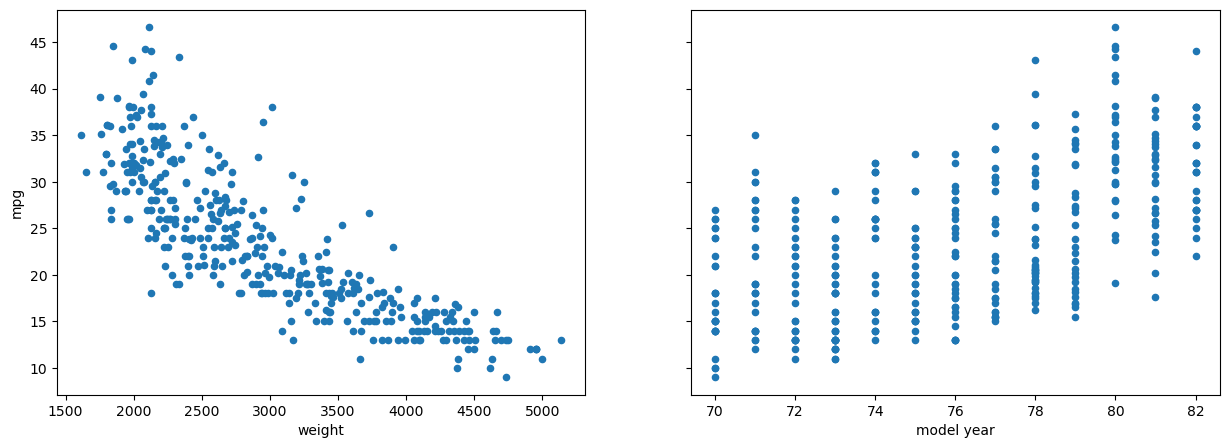

In [45]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
ax1.set_ylabel("mpg")

data.plot.scatter(x="weight", y="mpg", ax=ax1)
data.plot.scatter(x="model year", y="mpg", ax=ax2);

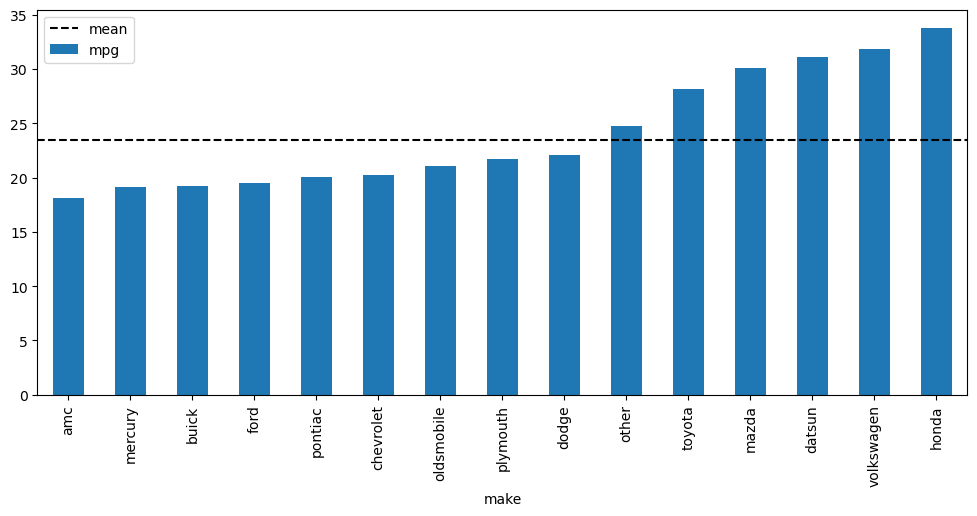

In [46]:
fig, ax = plt.subplots(figsize=(12,5))
data.groupby("make").mean('mpg').sort_values(by="mpg").plot.bar(y="mpg", ax=ax)
ax.axhline(y=data["mpg"].mean(), label="mean", color="black", linestyle="--")
ax.legend();

### Model Metrics

These features were fed into an ordinary least-squares multiple regression model. This model:

* is statistically significant overall (F-statistic p-value 5.53e-134)
* explains about 82% of the variance in MPG (adjusted R-Squared 0.824)
* is off by about 3.2 MPG in an average prediction (RMSE 3.2005653137923917)

### Model Diagnostics

Below are partial regression plots for all model features:

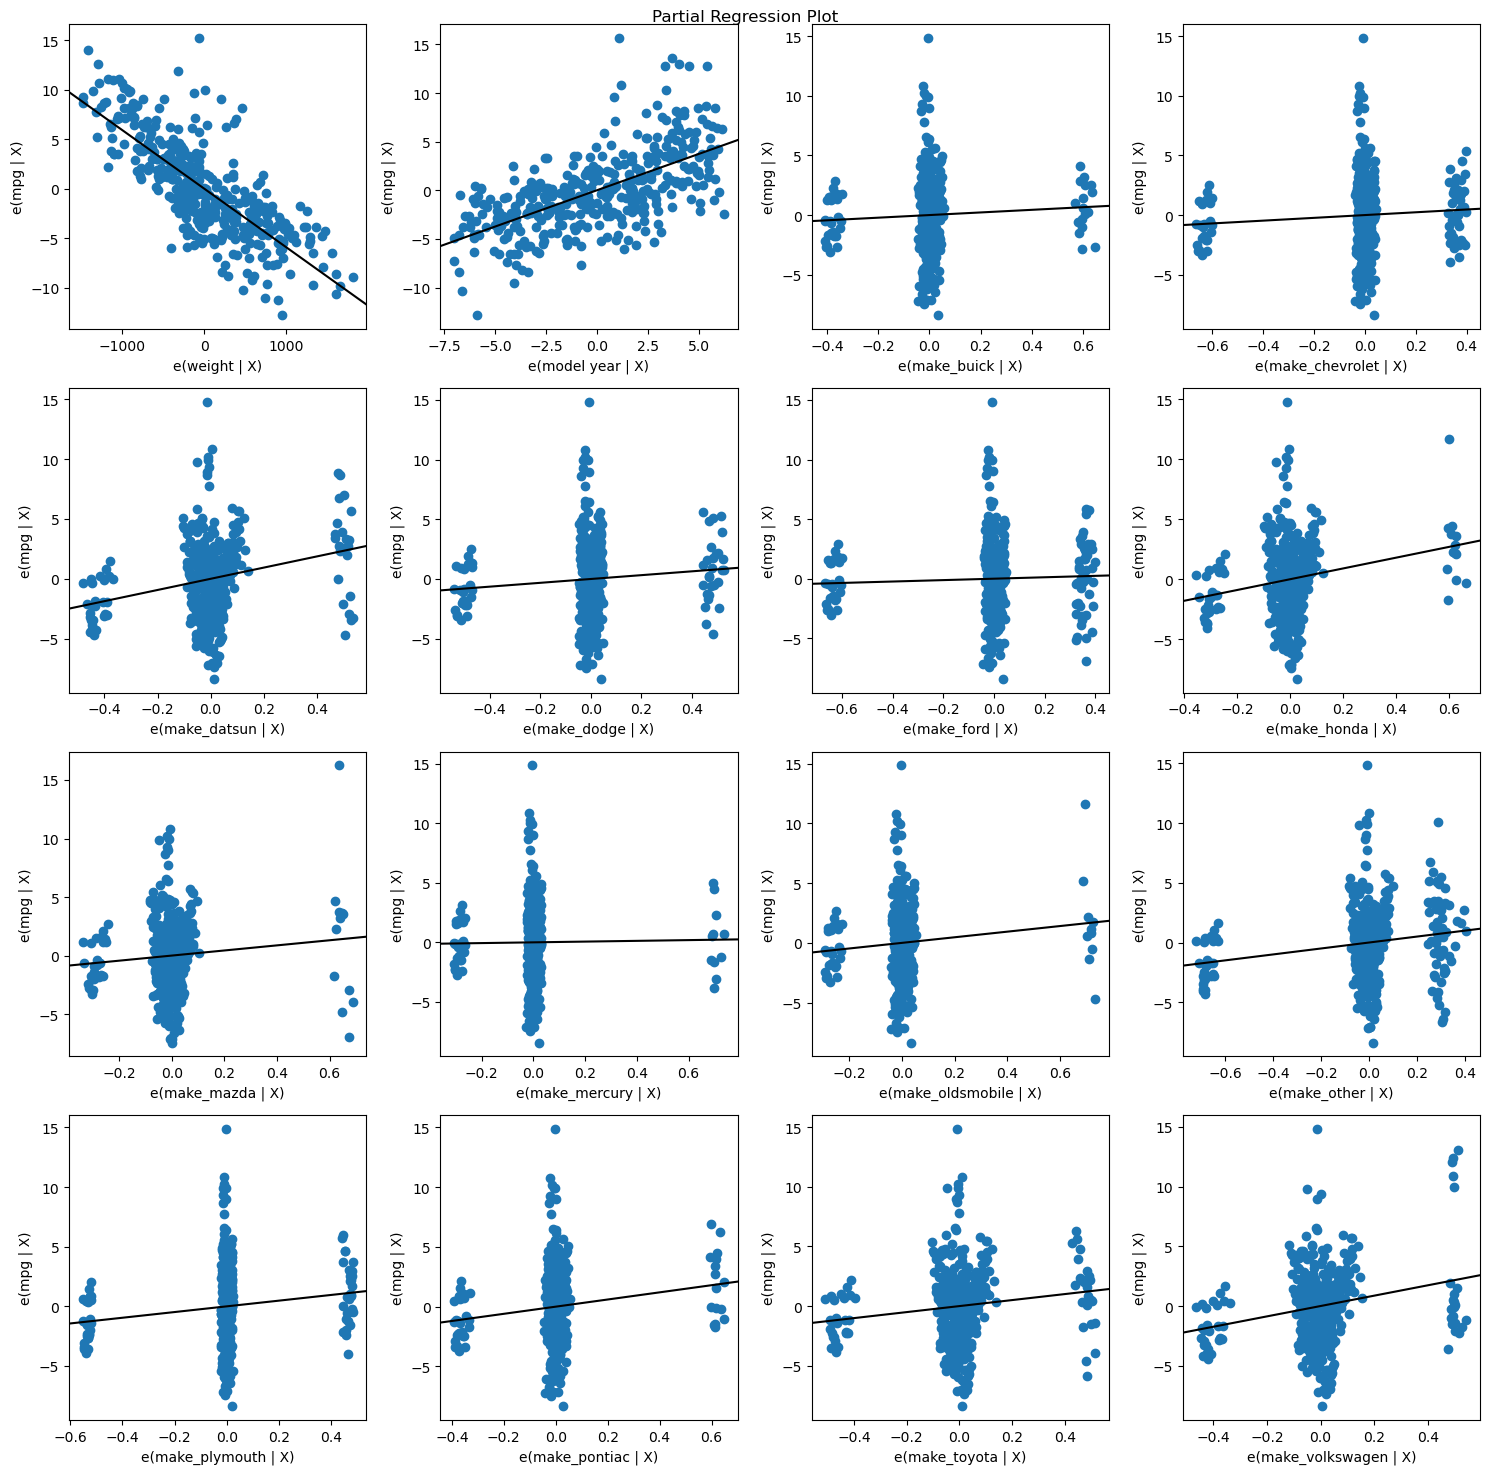

In [49]:
fig = plt.figure(figsize=(15,15))
sm.graphics.plot_partregress_grid(
    results,
    exog_idx=list(X.columns),
    grid=(4,4),
    fig=fig)
plt.tight_layout()
plt.show()

### Model Interpretation

Below are all model coefficients and p-values:

In [51]:
results_df = pd.concat([results.params, results.pvalues], axis=1)
results_df.columns = ["coefficient", "p-value"]
results_df

,coefficient,p-value
const,-17.587307,1.130022e-05
weight,-0.005941,4.720990e-76
model year,0.745954,1.321660e-41
make_buick,1.098322,2.833603e-01
make_chevrolet,1.170251,1.413107e-01
make_datsun,4.679217,1.828514e-06
make_dodge,1.602834,7.272445e-02
make_ford,0.595459,4.521172e-01
make_honda,4.495894,1.203801e-04
make_mazda,2.179408,6.434006e-02


And these are only coefficients with p-values below 0.05:

In [53]:
results_df = results_df[results_df["p-value"] < 0.05].sort_values(by="coefficient")
results_df

,coefficient,p-value
const,-17.587307,1.130022e-05
weight,-0.005941,4.720990e-76
model year,0.745954,1.321660e-41
make_plymouth,2.394280,5.804084e-03
make_other,2.491078,1.277613e-03
make_toyota,2.518955,7.148628e-03
make_pontiac,2.994904,4.237245e-03
make_volkswagen,4.346503,1.426705e-05
make_honda,4.495894,1.203801e-04
make_datsun,4.679217,1.828514e-06


Writing this out:

* For a car with `weight` and `model year` of 0 (i.e. weighing 0 lbs and built in 1900), as well as a `make` of `amc`, we would expect an MPG of about -17.6
  * It's ok that this is not a valid MPG, since a car weighing 0 lbs is not valid either
* For each increase of 1 lb in **weight**, we see an associated **decrease** in MPG of about .006
* For each year **newer** of a model, we see an associated **increase** in MPG of about 0.75
* Breaking down the `make`:
  * For a **Plymouth** vehicle compared to an AMC vehicle, we see an associated **increase** in MPG of about 2.4
  * For a **Toyota** vehicle compared to an AMC vehicle, we see an associated **increase** in MPG of about 2.5
  * For a **Pontiac** vehicle compared to an AMC vehicle, we see an associated **increase** in MPG of about 3.0
  * For a **Volkswagen** vehicle compared to an AMC vehicle, we see an associated **increase** in MPG of about 4.3
  * For a **Honda** vehicle compared to an AMC vehicle, we see an associated **increase** in MPG of about 4.5
  * For a **Datsun** vehicle compared to an AMC vehicle, we see an associated **increase** in MPG of about 4.7

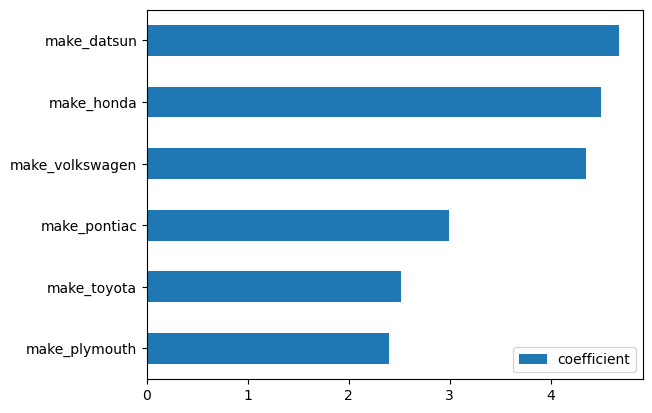

In [55]:
results_df.drop(["const", "weight", "model year", "make_other"]).plot.barh(y="coefficient");

Note that while we included `make` categories with higher p-values in the model, we did not report their coefficients. That is because we can't be confident that those coefficients aren't actually zero. Also we did not report a coefficient for `make_other` because this is not a particularly meaningful thing to explain to a stakeholder.

We also aren't plotting the `make` values on the same graph as the `weight` and `model year` values because they are all measured in different units (lbs vs. years vs. vehicle make), so it doesn't really make sense to compare them. Whereas it might be interesting to a stakeholder to see just the `make` values compared against each other.

## Summary

In this lesson you looked at several different multiple regression models, all built using one-hot encoded categorical features in addition to numeric features. You saw how the choice of a reference category impacts the interpretation of the coefficients, and also walked through several different examples of what to do and what not to do when you encounter a feature with many categories.